In [1]:
import numpy as np

import torch
import rlkit.torch.pytorch_util as ptu
from kornia.geometry.transform import warp_perspective, get_perspective_transform, get_rotation_matrix2d, warp_affine
from rlkit.data_management.obs_dict_replay_buffer import ObsDictReplayBuffer
from rlkit.misc.wx250_utils import add_data_to_buffer_real_robot, DummyEnv

import matplotlib.pyplot as plt
import os
gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
ptu.set_gpu_mode(True)

In [33]:
BUFFER_PATH = "/home/jonathan/Desktop/robonetv2/trainingdata/pinkplateleft/combined_2022-01-13_16_53_04_object_Puppet.pkl"

In [37]:
expl_env = DummyEnv(image_size=64, use_wrist=True)
replay_buffer = ObsDictReplayBuffer(
    int(1E6),
    expl_env,
    observation_keys=['image', 'state']
)
add_data_to_buffer_real_robot(BUFFER_PATH, replay_buffer)

replay_buffer._size 10440


In [4]:
print(replay_buffer._rewards[:replay_buffer._size].sum() / replay_buffer._size)
reward_rates = []
num_success = 0
for i in range(30000 // 15):
    traj = replay_buffer._rewards[15 * i:15 * (i + 1)]
    if 1 in traj:
        reward_rates.append(replay_buffer._rewards[15 * i:15 * (i + 1)].sum())
        num_success += 1
print(np.mean(reward_rates))
print(num_success / (30000 // 15))

0.15150421179302045
12.445227765726681
0.922


[1.]
[0.7176471  0.7176471  0.7176471  ... 0.4392157  0.3882353  0.46666667]


/home/jonathan/anaconda3/envs/railrl-env/lib/python3.6/site-packages/kornia/geometry/transform/imgwarp.py:184: UserWarning: The align_corners default value has been changed. By default now is set True in order to match cv2.warpAffine. In case you want to keep your previous behaviour set it to False. This warning will disappear in kornia > v0.6.
  warnings.warn(message)


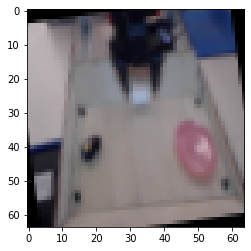

In [5]:
obs = replay_buffer._obs['image'][15 * 150]
print(replay_buffer._rewards[15 * 10000])
print(obs)
obs = ptu.from_numpy(obs.reshape(1, 3, 64, 64))
'''
dst_jitter = np.random.uniform(-6, 6, size=(1, 4, 2))
src = np.array([[[0, 0], [0, 64], [64, 0], [64, 64]]])
dst = np.clip(src - dst_jitter, 0, 64)
src = ptu.from_numpy(src)
dst = ptu.from_numpy(dst)
obs = warp_perspective(obs, get_perspective_transform(src, dst), dsize=(64, 64))
'''
center = ptu.from_numpy(np.array([[32, 32]]))
angle = ptu.from_numpy(np.random.uniform(-10, 10, size=(1,)))
scale = ptu.from_numpy(np.array([[1, 1]]))
m = get_rotation_matrix2d(center, angle, scale)
obs = warp_affine(obs, m, dsize=(64, 64))
obs = obs.detach().cpu().numpy()[0]
plt.imshow(obs.transpose((1, 2, 0)))

In [40]:
success_idxs = []
for i in range(100000):
    if replay_buffer._rewards[i] == 1:
        success_idxs.append(i)
        


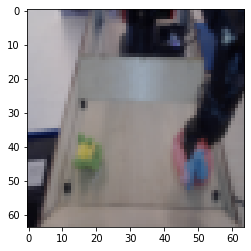

In [46]:
obs = replay_buffer._obs['image'][success_idxs[60]]
plt.imshow(obs.reshape(3, 64, 64).transpose((1, 2, 0)))